In [3]:
# Import necessary packages
import contextily as ctx
import folium
import geopy.distance
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from operator import itemgetter
import itertools
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

In [4]:
# Specify the center location (latitude, longtitude)
##japan
CENTER_LOCATION = (35.6889646, 139.7816839)

##india 
#CENTER_LOCATION = (51.4638, 0.6500)

# Specify distance in meters
DIST = 600  ##range of map you want around centre

# Specify the number of vehicles
NUM_VEHICLES = 10

/tmp/ipykernel_12368/3682450694.py:4: FutureWarning: The `get_largest_component` function is deprecated and will be removed in the v2.0.0 release. Replace it with `truncate.largest_component` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.utils_graph.get_largest_component(G, strongly=True)


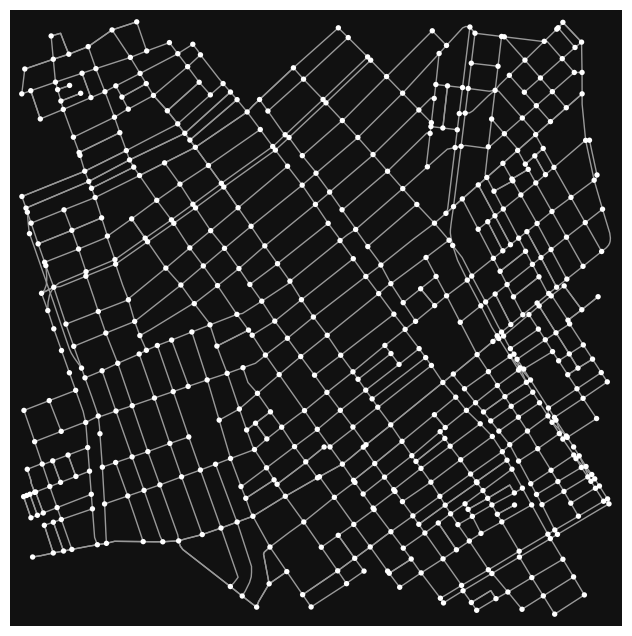

Node 257371953: Coordinates (139.7765254, 35.6878892)
Node 260102613: Coordinates (139.7855541, 35.6843997)
Node 260102616: Coordinates (139.7875876, 35.686471)
Node 260102617: Coordinates (139.7870323, 35.6871706)
Node 260102619: Coordinates (139.7860467, 35.6884203)
Node 260102622: Coordinates (139.7847558, 35.6902959)
Node 260102624: Coordinates (139.7848584, 35.6923987)
Node 265887785: Coordinates (139.7755534, 35.6894263)
Node 271660876: Coordinates (139.7770065, 35.6848807)
Node 304479751: Coordinates (139.7882226, 35.6856879)
Node 345118815: Coordinates (139.7877316, 35.6922058)
Node 345118816: Coordinates (139.787922, 35.6914815)
Node 345118821: Coordinates (139.7786216, 35.6849256)
Node 345119352: Coordinates (139.7774511, 35.6920205)
Node 345119908: Coordinates (139.778058, 35.6930226)
Node 345121604: Coordinates (139.7846046, 35.6908796)
Node 345135706: Coordinates (139.7845355, 35.6878048)
Node 384612065: Coordinates (139.7771859, 35.6926269)
Node 384616882: Coordinates (13

In [5]:
# Get the highway graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
# Remove unreachable nodes from the graph
G = ox.utils_graph.get_largest_component(G, strongly=True)
*_, = ox.plot_graph(G)

# Get the coordinates of each node in the graph
node_coordinates = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Print the coordinates of each node
for node, coordinates in node_coordinates.items():
    print(f"Node {node}: Coordinates {coordinates}")


In [6]:
# Use the nearest node to the center location as the depot
##to do select depot location
depot = ox.distance.nearest_nodes(G, CENTER_LOCATION[1], CENTER_LOCATION[0])  ##locations of depot

##select hotspot location
##rn exsisting node
hotspot_id =  9965375845
hotspot_location = (G.nodes[hotspot_id]['y'], G.nodes[hotspot_id]['x'])  # Adjust this as needed
hotspot = ox.distance.nearest_nodes(G, hotspot_location[1], hotspot_location[0])

In [7]:
# To do : replace this with customer orders
##how generate actual order locations  coordinates
##predined geometry of bus stops

orders = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)

# Get the nearest nodes to bus stops
orders_nodes = list(map(itemgetter(1), orders.index.values))
orders_nodes[:5]


/tmp/ipykernel_12368/70411485.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  orders = ox.geometries_from_point(CENTER_LOCATION, {"highway": "bus_stop"}, dist=DIST)


[1892744308, 1937182801, 2264347181, 2365963948, 2365963997]

In [8]:
# Combine depot and hotspots to customers
##get id of each node
nodes = [depot] + orders_nodes + [hotspot]  #depot 0th node , hotspot last node  
print(nodes) ##first depot last hotspot

[1054155212, 1892744308, 1937182801, 2264347181, 2365963948, 2365963997, 2365964017, 2365964040, 2365964047, 2366876978, 3977436330, 4005256766, 4005320452, 5021209549, 5832384987, 6376072071, 6376128150, 9349818268, 9349818269, 9510182277, 9510182278, 9510182279, 9510182280, 9510182282, 9712992080, 9712992081, 9712992082, 9965375845]


In [9]:
# Add order points to the highway graph
for index, order in orders.iterrows(): 
    ##nearest node  actual point on world to order location
    nearest_node = ox.distance.nearest_nodes(G, order.geometry.x, order.geometry.y)
    ## distance between the nearest node and the current order point
    distance = geopy.distance.distance((G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x']), (order.geometry.y, order.geometry.x))
    ##add order point to ,map
    G.add_node(index[1], x=order.geometry.x, y=order.geometry.y)
    
    # Add bidirectional edge
    G.add_edge(index[1], nearest_node, weight=distance.m)
    G.add_edge(nearest_node, index[1], weight=distance.m)

# Get edges as GeoDataFrames
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
edges.head()


osmid oneway  ref   name        highway  \
u         v          key                                                
257371953 1054597774 0     38790699   True  316   昭和通り        primary   
260102613 1105290724 0    157292782   True   50  新大橋通り        primary   
          1093866648 0    667863948   True  NaN    NaN    residential   
260102616 1105290727 0    368086828   True  NaN  清洲橋通り       tertiary   
          3719485540 0    368086842   True   50  清洲橋通り  tertiary_link   

                         reversed  length  \
u         v          key                    
257371953 1054597774 0      False  81.798   
260102613 1105290724 0      False  72.710   
          1093866648 0      False  69.784   
260102616 1105290727 0      False  25.523   
          3719485540 0      False  56.576   

                                                                   geometry  \
u         v          key                                                      
257371953 1054597774 0    LINESTRING (139.77653 35.68789, 139.77668 35.6...   
260102613 1105290724 0    LINESTRING (139.78555 35.68440, 139.78566 35.6...   
          1093866648 0    LINESTRING (139.78555 35.68440, 139.78550 35.6...   
260102616 1105290727 0    LINESTRING (139.78759 35.68647, 139.78774 35.6...   
          3719485540 0    LINESTRING (139.78759 35.68647, 139.78785 35.6...   

                         lanes access maxspeed  weight tunnel  
u         v          key                                       
257371953 1054597774 0     NaN    NaN      NaN     NaN    NaN  
260102613 1105290724 0       2    NaN      NaN     NaN    NaN  
          1093866648 0     NaN    NaN      NaN     NaN    NaN  
260102616 1105290727 0     NaN    NaN      NaN     NaN    NaN  
          3719485540 0     NaN    NaN      NaN     NaN    NaN

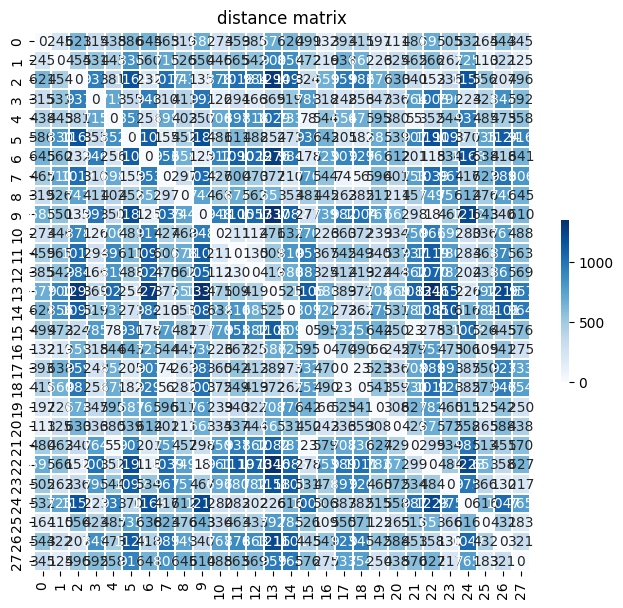

In [10]:
# Initialize an empty distance matrix
distance = {}

# Compute the pairwise distances between all nodes
for i in nodes:
    for j in nodes:
        # Calculate the distance between node i and node j
        distance[(i, j)] = geopy.distance.distance((G.nodes[i]['y'], G.nodes[i]['x']),
                                                    (G.nodes[j]['y'], G.nodes[j]['x'])).meters


#Convert the distance dictionary to a matrix
#Assuming orders_nodes is a list of node IDs
n = len(nodes)
distances = [[distance[(nodes[i], nodes[j])] for j in range(n)] for i in range(n)]
distances = np.array(distances)

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()    

In [11]:
# solve with pulp

def Optimize(vehicle_count,customer_count,x,distances,vehicle_capacity =3): ##distance is a distange matric

    for vehicle_count in range(1,vehicle_count+1):

        # definition of LpProblem instance
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        # definition of variables which are 0/1
        ##already includes constaraint sum(Xii) = 0
        x = x
        #x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
        u = pulp.LpVariable.dicts('u', (i for i in range(1, customer_count)), lowBound=0, cat='integer')

        # add objective function
        problem += pulp.lpSum(distances[i][j] * x[i][j][k] if i != j else 0
                            for k in range(vehicle_count)
                            for j in range(customer_count)
                            for i in range (customer_count))

        #constraints

    # pickup all points with exact;y one cab
        for j in range(1,customer_count-1):
            problem += pulp.lpSum(x[i][j][k] for i in range(customer_count) for k in range(vehicle_count)) == 1


        #depart from 0
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 0

        #arrive at 15
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[i][customer_count-1][k] for i in range(customer_count-1)) == 1
            problem += pulp.lpSum(x[customer_count-1][j][k] for j in range(customer_count-1)) == 0


        ##given vehicle demand is less than capacity
        for k in range(vehicle_count):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                for i in range(customer_count) for j in range(customer_count)) <= vehicle_capacity

    #if arrive then leave
        for k in range(vehicle_count):
            for j in range(1,customer_count-1):
                problem += pulp.lpSum( pulp.lpSum(x[i][j][k] for i in range(0,customer_count-1)) ) == ( pulp.lpSum(x[j][m][k] for m in range(1,customer_count)) )

    # xij and xji not both 1
        for k in range(vehicle_count):
            for j in range(1,customer_count-1):
                for i in range(1,customer_count-1):
                    if (x[i][j][k] if i != j else 0  ==1 ):
                        problem += x[j][i][k] ==0

        #elimnate subtours
        # Subtour Elimination (MTZ constraints)
        for i in range(1, customer_count):
            problem += u[i] >= 1  # Ensures that each node (except the depot) is visited at least once
            problem += u[i] <= customer_count - 1  # Sets an upper bound for u[i]
        for k in range(vehicle_count):
            for i in range(1, customer_count):
                for j in range(1, customer_count):
                    if i != j:
                        problem += u[i] - u[j] + (customer_count - 1) * x[i][j] <= customer_count- 2

    # solve problem
        status = problem.solve()
        print(status)


        if status == 1:
            print('Vehicle Requirements:', vehicle_count)
            print('Moving Distance:', pulp.value(problem.objective))
            return vehicle_count
            break
    

In [12]:
print(NUM_VEHICLES)
x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(NUM_VEHICLES)]for j in range(n)] for i in range(n)]
v = Optimize(NUM_VEHICLES,n,x,distances)

10
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/27ac3a9170234d2dbcf2f3a944b1e394-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/27ac3a9170234d2dbcf2f3a944b1e394-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 818 COLUMNS
At line 27119 RHS
At line 27933 BOUNDS
At line 35008 ENDATA
Problem MODEL has 813 rows, 7101 columns and 11396 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.01 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.03   (Wallclock seconds):       0.03

-1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/prachit/.local/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/5d6cbb826afa4a719733fad571ad8c24-pulp.mps -t

In [13]:
# Create map object
m = folium.Map(location=CENTER_LOCATION, zoom_start=16)

# Plot depot
depot_coords = (G.nodes[depot]['y'], G.nodes[depot]['x'])
folium.Marker(location=depot_coords, icon=folium.Icon(color='red', icon='home', prefix='fa'), tooltip=f"Depot {depot_coords}").add_to(m)

# # Plot customer locations
# for index, order in orders.iterrows():
#     stop_coords = (order.geometry.y, order.geometry.x)
#     folium.Marker(location=stop_coords, icon=folium.Icon(color='green', icon='bus', prefix='fa'), tooltip=f"Bus Stop {stop_coords}").add_to(m)

# Create colors for routes
colors = ['blue', 'orange', 'purple', 'green']
routes = []
for k in range(v):
    # Get routes for each vehicle
    vehicle_routes = [(i, j) for i in range(n) for j in range(n) if i != j and pulp.value(x[i][j][k]) == 1]

    # Choose color for this vehicle
    color = colors[k % len(colors)]  # Cycle through colors if more vehicles than colors

    # Plot each route for this vehicle
    for i, j in vehicle_routes:
        # Get the coordinates of the nodes i and j
        coord_i = (G.nodes[nodes[i]]['y'], G.nodes[nodes[i]]['x'])
        coord_j = (G.nodes[nodes[j]]['y'], G.nodes[nodes[j]]['x'])

        # Add markers for depot, hotspot, and customer nodes
        folium.Marker((G.nodes[hotspot]['y'], G.nodes[hotspot]['x']), icon=folium.Icon(color="red"), popup="Hotspot").add_to(m)
        folium.Marker((G.nodes[depot]['y'], G.nodes[depot]['x']), icon=folium.Icon(color="green"), popup="Depot").add_to(m)
        for customer_node in orders_nodes:
            folium.Marker((G.nodes[customer_node]['y'], G.nodes[customer_node]['x']), icon=folium.Icon(color="black"), popup="Customer").add_to(m)

        # Draw a line between the nodes to represent the route
        folium.PolyLine([coord_i, coord_j], color=color, weight=2.5, opacity=1).add_to(m)

# Display the map
m

TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
# Create a Folium map centered at a specific location
m = folium.Map(location=CENTER_LOCATION, zoom_start=12)
colors = ['blue', 'orange', 'purple', 'green']
# Plot routes
for k in range(v):
    # Get routes for each vehicle
    vehicle_routes = [(i, j) for i in range(n) for j in range(n) if i != j and pulp.value(x[i][j][k]) == 1]

    # Choose color for this vehicle
    color = colors[k % len(colors)]  # Cycle through colors if more vehicles than colors

    # Plot each route for this vehicle
    for i, j in vehicle_routes:
        route_nodes = nx.shortest_path(G, nodes[i], nodes[j], weight='length')
        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in route_nodes]
        
        # Add markers for depot, hotspot, and customer nodes
        folium.Marker((G.nodes[hotspot]['y'], G.nodes[hotspot]['x']), icon=folium.Icon(color="red"), popup="Hotspot").add_to(m)
        folium.Marker((G.nodes[depot]['y'], G.nodes[depot]['x']), icon=folium.Icon(color="green"), popup="Depot").add_to(m)
        for customer_node in orders_nodes:
            folium.Marker((G.nodes[customer_node]['y'], G.nodes[customer_node]['x']), icon=folium.Icon(color="black"), popup="Customer").add_to(m)

        # Draw a line between the route nodes to represent the route
        folium.PolyLine(route_coords, color=color, weight=2.5, opacity=1).add_to(m)

# Display the map
m
